In [1]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
from tensorflow import keras as keras
import numpy as np
import random
from keras.models import Model
from keras.layers import Input, Flatten, Dense,Lambda,Reshape
from keras.layers import AveragePooling1D,Conv1D
from keras import backend as K
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GroupKFold 


In [2]:
#Siamese Network Implementation 
num_classes = 12
epochs = 20
 
def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))
 
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)
 
def contrastive_loss(y_true, y_pred):
    y_true=tf.cast(y_true, tf.float32)
    y_pred=tf.cast(y_pred, tf.float32)
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)


def create_pairs_new3(x, digit_indices):
    pairs = []
    labels = []
    
    for d in range(num_classes):
        # Skip if no samples for this class
        if len(digit_indices[d]) == 0:
            continue
            
        n = len(digit_indices[d]) - 1
        if n <= 0:
            continue
            
        for i in range(n):
            # Create positive pair
            randomIndiceTrue = -1
            while True:
                if randomIndiceTrue != i:
                    break
                else:
                    randomIndiceTrue = random.randrange(0, len(digit_indices[d]))
            
            z1, z2 = digit_indices[d][i], digit_indices[d][randomIndiceTrue]
            pairs += [[x[z1], x[z2]]]
            labels += [1]  # Add positive label immediately
            
            # Find a different class that has samples for negative pair
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            
            # Keep trying until we find a class with samples
            attempts = 0
            while len(digit_indices[dn]) == 0 and attempts < num_classes:
                inc = random.randrange(1, num_classes)
                dn = (d + inc) % num_classes
                attempts += 1
            
            # If no other class has samples, create a dummy negative pair
            if len(digit_indices[dn]) == 0:
                # Use the same sample twice as a fallback
                z1, z2 = digit_indices[d][i], digit_indices[d][i]
                pairs += [[x[z1], x[z2]]]
                labels += [0]
            else:
                randomIndiceFalse = random.randrange(0, len(digit_indices[dn]))
                z1, z2 = digit_indices[d][i], digit_indices[dn][randomIndiceFalse]
                pairs += [[x[z1], x[z2]]]
                labels += [0]
                
    return np.array(pairs), np.array(labels)



def create_base_net_new2(input_shape):
    height=376
    depth=1
    num_classes=12
    input = Input(shape = input_shape)
    #x = Sequential()(input)
    x = Reshape((height, depth))(input)
    x = Conv1D(12, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(8, 3, strides=1, padding='valid', activation='relu')(x)
    x = AveragePooling1D(3)(x)
    x = Conv1D(6, 3, strides=1, padding='valid', activation='relu')(x)
    #x = AveragePooling1D(3)(x)
    x = Flatten()(x)
    x = Dense(num_classes, activation = 'relu')(x)
    model = Model(input, x)
    model.summary()
    #print(model.summary())
    return model


def get_f1(y_true, y_pred): 
    pred = K.cast(y_pred < 0.5, y_true.dtype)
    true_positives = K.sum(K.round(K.clip(y_true * pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

def compute_f1(y_true, y_pred):
    pred = y_pred.ravel() < 0.5
    pred=pred*1
    TN,FP,FN,TP=confusion_matrix(y_true, pred).ravel()

    recall = TP/(TP+FN)
    precision=TP/(TP+FP)

    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val




In [3]:
def compute_cosine_f1(t_pairs, t_y):
    # Set the cosine similarity threshold
    cosine_threshold = 0.6
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Iterate through the pairs and compute cosine similarity
    for i in range(np.shape(t_y)[0]):
        cos_result = cosine_similarity(t_pairs[i, 0].reshape(1, -1), t_pairs[i, 1].reshape(1, -1))
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and cos_result >= cosine_threshold:
            cTP = cTP + 1
        elif t_y[i] != 1 and cos_result >= cosine_threshold:
            cFP = cFP + 1
        elif t_y[i] == 1 and cos_result < cosine_threshold:
            cFN = cFN + 1
        elif t_y[i] != 1 and cos_result < cosine_threshold:
            cTN = cTN + 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score
    f1_cosine_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_cosine_val


In [4]:
def manhattan_distance(point1, point2):
    return np.sum(np.abs(point1 - point2))

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_manhattan_f1(t_pairs, t_y):
    manhattan_threshold = 0.9

    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalizasyonu
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])

    # Iterate through the pairs and compute Manhattan distance
    for i in range(np.shape(t_y)[0]):
        result = manhattan_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1])

        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result >= manhattan_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= manhattan_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < manhattan_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < manhattan_threshold:
            cTN += 1

    # Calculate recall  
    recall = cTP / (cTP + cFN)

    # Calculate precision
    precision = cTP / (cTP + cFP)

    # Calculate the F1 score for Manhattan distance
    f1_manhattan_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_manhattan_val


In [5]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_euclidean_f1(t_pairs, t_y):
    # Set the Euclidean distance threshold
    euclidean_threshold = 0.7
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    # Max-Min Normalization
    t_pairs_normalized = np.array([min_max_normalize(pair) for pair in t_pairs])
    
    # Iterate through the pairs and compute Euclidean distance
    for i in range(np.shape(t_y)[0]):
        result = euclidean_distance(t_pairs_normalized[i, 0], t_pairs_normalized[i, 1])
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result >= euclidean_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= euclidean_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < euclidean_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < euclidean_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Euclidean distance
    f1_euclidean_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_euclidean_val


In [6]:
from scipy.stats import pearsonr

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_pearsonr_f1(t_pairs, t_y):
    # Set the Pearson correlation coefficient threshold
    pearsonr_threshold = 0.65
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the 2-D arrays to 1-D arrays
        t_pair_normalized_1d = t_pair_normalized[0].flatten()
        t_pair_normalized_2d = t_pair_normalized[1].flatten()
        
        # Calculate the Pearson correlation coefficient
        result, _ = pearsonr(t_pair_normalized_1d, t_pair_normalized_2d)
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and abs(result) >= pearsonr_threshold:
            cTP += 1
        elif t_y[i] != 1 and abs(result) >= pearsonr_threshold:
            cFP += 1
        elif t_y[i] == 1 and abs(result) < pearsonr_threshold:
            cFN += 1
        elif t_y[i] != 1 and abs(result) < pearsonr_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Pearson correlation coefficient
    f1_pearsonR_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_pearsonR_val


In [7]:
from scipy.spatial.distance import braycurtis

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_bray_curtis_f1(t_pairs, t_y):
    # Set the Bray-Curtis dissimilarity threshold
    bray_curtis_threshold = 0.6
    
    # Initialize variables for true positives, false positives, false negatives, and true negatives
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D
        t_pair_normalized_1d = t_pair_normalized[0].flatten()
        t_pair_normalized_2d = t_pair_normalized[1].flatten()
        
        # Calculate the Bray-Curtis dissimilarity
        result = braycurtis(t_pair_normalized_1d, t_pair_normalized_2d)
        
        # Check conditions for true positive, false positive, false negative, and true negative
        if t_y[i] == 1 and result <= bray_curtis_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= bray_curtis_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > bray_curtis_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > bray_curtis_threshold:
            cTN += 1
        
    # Calculate recall
    recall = cTP / (cTP + cFN)
    
    # Calculate precision
    precision = cTP / (cTP + cFP)
    
    # Calculate the F1 score for Bray-Curtis dissimilarity
    f1_bray_curtis_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_bray_curtis_val


In [8]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def calculate_jaccard_similarity(set1, set2):
    intersection = np.sum(set1 & set2)
    union = np.sum(set1 | set2)
    if union == 0:
        return 0.0
    return intersection / union

def compute_jaccard_f1(t_pairs, t_y):
    jaccard_threshold = 0.4
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D and convert to binary (0 or 1)
        t_pair_normalized_1d = (t_pair_normalized[0] >= 0.5).astype(int)
        t_pair_normalized_2d = (t_pair_normalized[1] >= 0.5).astype(int)
        
        # Calculate the Jaccard similarity
        result = calculate_jaccard_similarity(t_pair_normalized_1d, t_pair_normalized_2d)
        
        if t_y[i] == 1 and result >= jaccard_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= jaccard_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < jaccard_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < jaccard_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_jaccard_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_jaccard_val


In [9]:
from scipy.spatial.distance import canberra

def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_canberra_f1(t_pairs, t_y):
    canberra_threshold = 0.7
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply Max-Min normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Calculate Canberra distance after normalization
        result = canberra(t_pair_normalized[0].flatten(), t_pair_normalized[1].flatten())  # Flatten to 1-D arrays
        
        if t_y[i] == 1 and result >= canberra_threshold:
            cTP += 1
        elif t_y[i] != 1 and result >= canberra_threshold:
            cFP += 1
        elif t_y[i] == 1 and result < canberra_threshold:
            cFN += 1
        elif t_y[i] != 1 and result < canberra_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_canberra_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_canberra_val


In [10]:
import numpy as np

def hamming_distance(vector1, vector2):
    return np.sum(vector1 != vector2)

def compute_hamming_f1(t_pairs, t_y):
    hamming_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0

    for i in range(np.shape(t_y)[0]):
        t_pair = t_pairs[i]  # Get the pair of vectors

        # Calculate Hamming distance using the previously defined hamming_distance function
        result = hamming_distance(t_pair[0], t_pair[1])

        if t_y[i] == 1 and result <= hamming_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= hamming_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > hamming_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > hamming_threshold:
            cTN += 1

    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_hamming_val = 2 * (precision * recall) / (precision + recall)

    return f1_hamming_val


In [11]:
def min_max_normalize(data):
    min_val = np.min(data)
    max_val = np.max(data)
    normalized_data = (data - min_val) / (max_val - min_val)
    return normalized_data

def compute_hamming_f1(t_pairs, t_y):
    hamming_threshold = 0.9
    cTP = 0
    cFP = 0
    cFN = 0
    cTN = 0
    
    for i in range(np.shape(t_y)[0]):
        # Apply min-max normalization to each pair
        t_pair_normalized = np.array([min_max_normalize(pair) for pair in t_pairs[i]])
        
        # Flatten the arrays to 1-D and convert to binary (0 or 1)
        t_pair_normalized_1d = (t_pair_normalized[0] >= 0.5).astype(int)
        t_pair_normalized_2d = (t_pair_normalized[1] >= 0.5).astype(int)
        
        # Calculate Hamming distance
        result = np.sum(t_pair_normalized_1d != t_pair_normalized_2d) / len(t_pair_normalized_1d)
        
        if t_y[i] == 1 and result <= hamming_threshold:
            cTP += 1
        elif t_y[i] != 1 and result <= hamming_threshold:
            cFP += 1
        elif t_y[i] == 1 and result > hamming_threshold:
            cFN += 1
        elif t_y[i] != 1 and result > hamming_threshold:
            cTN += 1
        
    recall = cTP / (cTP + cFN)
    precision = cTP / (cTP + cFP)
    f1_hamming_val = 2 * (precision * recall) / (precision + recall)
    
    return f1_hamming_val


In [12]:
#Dataset
df=pd.read_csv('db_dep_dataset_1_noname.csv',delimiter=';',header=None)
df
# Table names are anonymized.
# First column: TABLE_UniqueTableNumber_ModuleNumber
# Second column: Class number. Equal to Module Number-1. There are 12 classes in totally.
# Third column: Unique table number

,0,1,2,3,4,5,6,7,8,9,...,369,370,371,372,373,374,375,376,377,378
0,TABLE_1_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TABLE_2_1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TABLE_3_1,0,3,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TABLE_4_1,0,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TABLE_5_1,0,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,TABLE_116_12,11,116,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
116,TABLE_117_12,11,117,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
117,TABLE_118_12,11,118,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
118,TABLE_119_12,11,119,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Separation X and Y values
Y = df[1]

Y=Y.values

# Define groups for GroupKFold (using unique table numbers from column 2)
groups = df[2].values

#First three columns removed.
X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)

X=X.values

In [14]:
Y = df[1]

Y=Y.values

# Define groups for GroupKFold (using unique table numbers from column 2)
groups = df[2].values

X = df
X = X.drop(0,axis=1)
X = X.drop(1,axis=1)
X = X.drop(2,axis=1)
X=X.values

cvTestscoresSiameseAll=[]
cvTestscoresCosineAll=[]
cvTestscoresManhattanAll=[]
cvTestscoresEuclideanAll=[]
cvTestscoresBrayCurtisAll=[]
cvTestscoresPearsonRAll=[]
cvTestscoresJaccardAll=[]
cvTestscoresHammingAll=[]
cvTestscoresCanberraAll=[]

for i in range(100):
    
    kfold = GroupKFold(n_splits=5)
    cvTrainscores = []
    cvTestscores = []
    cvi=0
    cvTrainscoresCosine = []
    cvTestscoresCosine = []

    cvTrainscoresManhattan =[]
    cvTestscoresManhattan =[]

    cvTrainscoresEuclidean =[]
    cvTestscoresEuclidean =[]

    cvTrainscoresBrayCurtis =[]
    cvTestscoresBrayCurtis =[]


    cvTrainscoresPearsonR =[]
    cvTestscoresPearsonR =[]

    cvTrainscoresJaccard =[]
    cvTestscoresJaccard =[]

    cvTrainscoresHamming =[]
    cvTestscoresHamming =[]

    cvTrainscoresCanberra =[]
    cvTestscoresCanberra =[]

    
    for train, test in kfold.split(X, Y, groups):
        
        cvi=cvi+1
        print("n-fold: "+str(cvi))

        x_train = X[train]
        x_test = X[test]
        y_train = Y[train]
        y_test = Y[test]

        x_train = x_train.reshape(x_train.shape[0], 376, 1)
        x_test = x_test.reshape(x_test.shape[0], 376, 1)
        input_shape = (376, 1)
        print(x_train.shape)
        x_train = x_train.astype('float32')
        x_test = x_test.astype('float32')
        y_train = y_train.astype('float32')
        y_test = y_test.astype('float32')
        input_shape = (376,1)

        print(input_shape)

        # create training+test positive and negative pairs
        digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
        tr_pairs, tr_y = create_pairs_new3(x_train, digit_indices)

        digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
        te_pairs, te_y = create_pairs_new3(x_test, digit_indices)

        # network definition
        base_network = create_base_net_new2(input_shape)

        print(input_shape)

        input_a = Input(shape=input_shape)
        input_b = Input(shape=input_shape)

        processed_a = base_network(input_a)
        processed_b = base_network(input_b)

        distance = Lambda(euclid_dis,
                      output_shape=eucl_dist_output_shape)([processed_a, processed_b])

        model = Model([input_a, input_b], distance)

        #train
        model.compile(loss=contrastive_loss, optimizer='adam', metrics=[get_f1])

        model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
              batch_size=16,
              epochs=epochs,
              validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

        # compute final accuracy on training and test sets for n-fold
        p=2
        y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
        tr_acc = compute_f1(tr_y, y_pred)
        tr_f1_cosine = compute_cosine_f1(tr_pairs,tr_y)
        tr_f1_manhattan = compute_manhattan_f1(tr_pairs,tr_y)
        tr_f1_bray_curtis = compute_bray_curtis_f1(tr_pairs,tr_y)
        tr_f1_euclidean = compute_euclidean_f1(tr_pairs,tr_y)
        tr_f1_pearsonR = compute_pearsonr_f1(tr_pairs,tr_y)
        tr_f1_jaccard = compute_jaccard_f1(tr_pairs,tr_y)
        tr_f1_hamming = compute_hamming_f1(tr_pairs,tr_y)
        tr_f1_canberra = compute_canberra_f1(tr_pairs,tr_y)

        

        y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
        te_acc = compute_f1(te_y, y_pred)
        te_f1_cosine = compute_cosine_f1(te_pairs,te_y)
        te_f1_manhattan = compute_manhattan_f1(tr_pairs,tr_y)
        te_f1_bray_curtis = compute_bray_curtis_f1(tr_pairs,tr_y)
        te_f1_euclidean = compute_euclidean_f1(tr_pairs,tr_y)
        te_f1_pearsonR = compute_pearsonr_f1(tr_pairs,tr_y)
        te_f1_jaccard = compute_jaccard_f1(tr_pairs,tr_y)
        te_f1_hamming = compute_hamming_f1(tr_pairs,tr_y)
        te_f1_canberra = compute_canberra_f1(tr_pairs,tr_y)



        cvTrainscores.append(100 * tr_acc)
        cvTestscores.append(100 * te_acc)

        cvTrainscoresCosine.append(100 * tr_f1_cosine)
        cvTestscoresCosine.append(100 * te_f1_cosine)

        cvTrainscoresManhattan.append(100 * tr_f1_manhattan)
        cvTestscoresManhattan.append(100 * te_f1_manhattan)

        cvTrainscoresBrayCurtis.append(100 * tr_f1_bray_curtis)
        cvTestscoresBrayCurtis.append(100 * te_f1_bray_curtis)

        cvTrainscoresEuclidean.append(100 * tr_f1_euclidean)
        cvTestscoresEuclidean.append(100 * te_f1_euclidean)
        
        cvTrainscoresPearsonR.append(100 * tr_f1_pearsonR)
        cvTestscoresPearsonR.append(100 * te_f1_pearsonR)

        cvTrainscoresJaccard.append(100 * tr_f1_jaccard)
        cvTestscoresJaccard.append(100 * te_f1_jaccard)

        cvTrainscoresHamming.append(100 * tr_f1_hamming)
        cvTestscoresHamming.append(100 * te_f1_hamming)

        cvTrainscoresCanberra.append(100 * tr_f1_canberra)
        cvTestscoresCanberra.append(100 * te_f1_canberra)


    
    cvTestscoresSiameseAll.append(np.mean(cvTestscores))
    cvTestscoresCosineAll.append(np.mean(cvTestscoresCosine))
    cvTestscoresManhattanAll.append(np.mean(cvTestscoresManhattan))
    cvTestscoresBrayCurtisAll.append(np.mean(cvTestscoresBrayCurtis))
    cvTestscoresEuclideanAll.append(np.mean(cvTestscoresEuclidean))
    cvTestscoresPearsonRAll.append(np.mean(cvTestscoresPearsonR))
    cvTestscoresJaccardAll.append(np.mean(cvTestscoresJaccard))
    cvTestscoresHammingAll.append(np.mean(cvTestscoresHamming))
    cvTestscoresCanberraAll.append(np.mean(cvTestscoresCanberra))

    



n-fold: 1
(96, 376, 1)
(376, 1)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 376, 1)]          0         
                                                                 
 reshape (Reshape)           (None, 376, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 374, 12)           48        
                                                                 
 average_pooling1d (Average  (None, 124, 12)           0         
 Pooling1D)                                                      
                                                                 
 conv1d_1 (Conv1D)           (None, 122, 8)            296       
                                                                 
 average_pooling1d_1 (Avera  (None, 40, 8)             0         
 gePooling1D)              

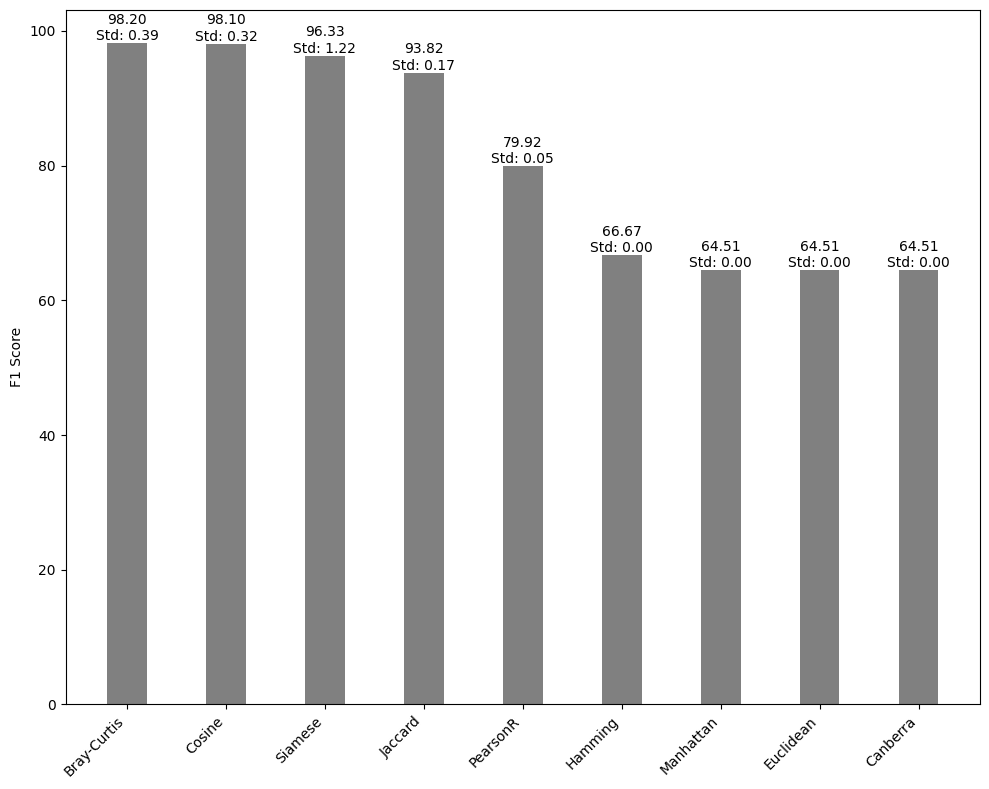

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data for the test scores
methods = ["Siamese", "Cosine", "Manhattan", "Bray-Curtis", "Euclidean", "PearsonR", "Jaccard", "Hamming", "Canberra"]
test_means = [np.mean(cvTestscoresSiameseAll), np.mean(cvTestscoresCosineAll), np.mean(cvTestscoresManhattanAll),
              np.mean(cvTestscoresBrayCurtisAll), np.mean(cvTestscoresEuclideanAll),
              np.mean(cvTestscoresPearsonRAll), np.mean(cvTestscoresJaccardAll), np.mean(cvTestscoresHammingAll),
              np.mean(cvTestscoresCanberraAll)]
test_stds = [np.std(cvTestscoresSiameseAll), np.std(cvTestscoresCosineAll), np.std(cvTestscoresManhattanAll),
             np.std(cvTestscoresBrayCurtisAll), np.std(cvTestscoresEuclideanAll),
             np.std(cvTestscoresPearsonRAll), np.std(cvTestscoresJaccardAll), np.std(cvTestscoresHammingAll),
             np.std(cvTestscoresCanberraAll)]

# Sort methods and corresponding test_means and test_stds in descending order of test means
sorted_methods, sorted_test_means, sorted_test_stds = zip(*sorted(zip(methods, test_means, test_stds), key=lambda x: x[1], reverse=True))

# Define the figure size
fig, ax = plt.subplots(figsize=(10, 8))

# Number of bars (one for each method)
num_methods = len(methods)
bar_width = 0.4
index = np.arange(num_methods)

# Create bars for test means
bar1 = ax.bar(index, sorted_test_means, bar_width, label='Test Mean', color='grey')

# Set the x-axis labels to be the sorted method names
ax.set_xticks(index)
ax.set_xticklabels(sorted_methods, rotation=45, ha='right')


ax.set_ylabel('F1 Score')


# Annotate the bars with their values and standard deviations, placing the standard deviation text above the bars
for i, (v, std) in enumerate(zip(sorted_test_means, sorted_test_stds)):
    ax.text(i, v + 0.01, f"{v:.2f}\nStd: {std:.2f}", ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


In [17]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresCosineAll)
result_df.describe()

,0
count,100.000000
mean,98.101304
std,0.320739
min,97.460870
25%,98.260870
50%,98.260870
75%,98.260870
max,98.260870


In [20]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresManhattanAll)
result_df.describe()

,0
count,1.000000e+02
mean,6.451260e+01
std,1.428245e-14
min,6.451260e+01
25%,6.451260e+01
50%,6.451260e+01
75%,6.451260e+01
max,6.451260e+01


In [21]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresBrayCurtisAll)
result_df.describe()

,0
count,100.000000
mean,98.204035
std,0.392553
min,97.122809
25%,97.910880
50%,98.199143
75%,98.481166
max,99.177142


In [22]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresEuclideanAll)
result_df.describe()

,0
count,1.000000e+02
mean,6.451260e+01
std,1.428245e-14
min,6.451260e+01
25%,6.451260e+01
50%,6.451260e+01
75%,6.451260e+01
max,6.451260e+01


In [23]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresPearsonRAll)
result_df.describe()

,0
count,100.000000
mean,79.921060
std,0.051117
min,79.714243
25%,79.943793
50%,79.943793
75%,79.943793
max,79.943793


In [24]:
result_df = pd.DataFrame(cvTestscoresSiameseAll)
result_df.describe()

,0
count,100.000000
mean,96.329856
std,1.222731
min,92.728205
25%,95.594206
50%,96.513702
75%,97.381818
max,99.200000


In [25]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresJaccardAll)
result_df.describe()

,0
count,100.000000
mean,93.821114
std,0.172722
min,93.337936
25%,93.688704
50%,93.806637
75%,93.923101
max,94.040814


In [26]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresHammingAll)
result_df.describe()

,0
count,100.000000
mean,66.666667
std,0.000000
min,66.666667
25%,66.666667
50%,66.666667
75%,66.666667
max,66.666667


In [27]:
#Overall Cosine Similarity Results for 100 Run
result_df = pd.DataFrame(cvTestscoresCanberraAll)
result_df.describe()

,0
count,1.000000e+02
mean,6.451260e+01
std,1.428245e-14
min,6.451260e+01
25%,6.451260e+01
50%,6.451260e+01
75%,6.451260e+01
max,6.451260e+01


In [28]:
#Overall Siamese Network Results for 100 Run
result_df = pd.DataFrame(cvTestscoresSiameseAll)
result_df.describe()

,0
count,100.000000
mean,96.329856
std,1.222731
min,92.728205
25%,95.594206
50%,96.513702
75%,97.381818
max,99.200000


Cosine scores statistics:
Mean: 98.1013
Std: 0.3191
Min: 97.4609
Max: 98.2609
Range: 0.8000


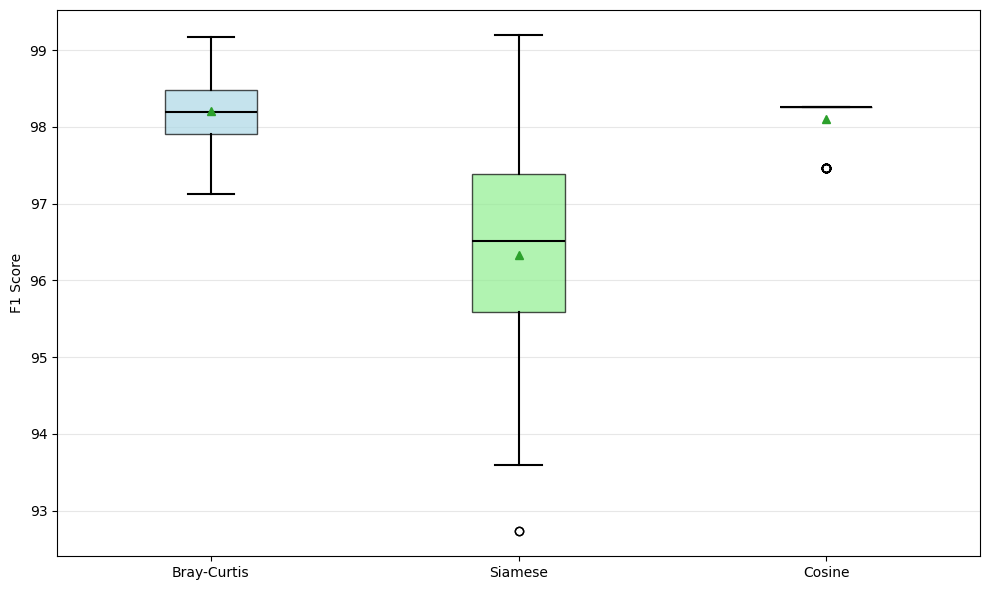

In [32]:
import matplotlib.pyplot as plt

data = [cvTestscoresBrayCurtisAll, cvTestscoresSiameseAll, cvTestscoresCosineAll]
names = ['Bray-Curtis', 'Siamese', 'Cosine']

# Check cosine data statistics
print("Cosine scores statistics:")
print(f"Mean: {np.mean(cvTestscoresCosineAll):.4f}")
print(f"Std: {np.std(cvTestscoresCosineAll):.4f}")
print(f"Min: {np.min(cvTestscoresCosineAll):.4f}")
print(f"Max: {np.max(cvTestscoresCosineAll):.4f}")
print(f"Range: {np.max(cvTestscoresCosineAll) - np.min(cvTestscoresCosineAll):.4f}")

fig, ax = plt.subplots(figsize=(10, 6))

# Customize boxplot appearance with better visibility
bp = ax.boxplot(data, tick_labels=names, patch_artist=True, showmeans=True)

# Set colors for each box
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Make whiskers and caps more visible
for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1.5)

ax.set_ylabel('F1 Score')
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()
